In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import math
gc.enable()

In [2]:
orders = pd.read_csv("orders.csv")
aisles = pd.read_csv("aisles.csv")
orders_product_prior = pd.read_csv("order_products__prior.csv")
orders_product_train = pd.read_csv("order_products__train.csv")
departments = pd.read_csv("departments.csv")
products = pd.read_csv("products.csv")

In [3]:
orders['eval_set'] = orders['eval_set'].astype('category')
aisles['aisle'] = aisles['aisle'].astype('category')
departments['department'] = departments['department'].astype('category')
products['product_name'] = products['product_name'].astype('category')

In [4]:
orders_total = pd.concat([orders_product_train,orders_product_prior])

In [5]:
product_stats = orders_total.groupby(['product_id'])['order_id'].count().to_frame("Times_bought").reset_index()

In [6]:
times_reordered_temp = orders_total.groupby(['product_id'])['reordered'].mean().to_frame("product_reordered_ratio").reset_index()

In [7]:
product_stats = product_stats.merge(times_reordered_temp,on='product_id',how='left')

In [8]:
cart_priority1 = orders_total.groupby(['product_id'])['add_to_cart_order'].mean().round().to_frame("avg_priority").reset_index()

In [9]:
product_stats = product_stats.merge(cart_priority1,on='product_id',how='left')

In [10]:
product_stats = product_stats.set_index("product_id")

In [11]:
del cart_priority1,times_reordered_temp
gc.collect()

16

In [12]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [13]:
wcss = [] 
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(product_stats.values)
    wcss.append(kmeans.inertia_)

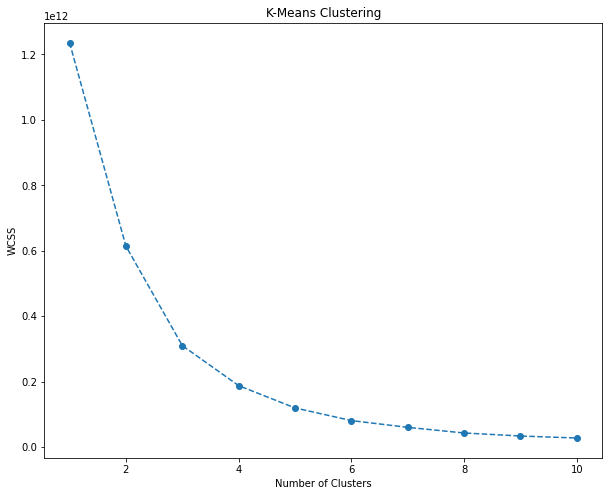

In [14]:
plt.figure(figsize=(10,8))
plt.plot(range(1,11),wcss, marker ='o', linestyle = '--')
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.title("K-Means Clustering")
plt.show()

In [15]:
kmeans_product = KMeans(n_clusters = 5, init='k-means++', random_state = 40)

In [16]:
sc = StandardScaler()

In [17]:
std_ps = sc.fit_transform(product_stats)

In [18]:
kmeans_product.fit(std_ps)

KMeans(n_clusters=5, random_state=40)

In [19]:
df_segm_kmeans = product_stats.reset_index().copy()

In [20]:
df_segm_kmeans

,product_id,Times_bought,product_reordered_ratio,avg_priority
0,1,1928,0.614627,6.0
1,2,94,0.138298,10.0
2,3,283,0.738516,6.0
3,4,351,0.458689,9.0
4,5,16,0.625000,6.0
...,...,...,...,...
49680,49684,9,0.111111,4.0
49681,49685,49,0.122449,10.0
49682,49686,127,0.700787,7.0
49683,49687,14,0.428571,7.0


In [21]:
df_segm_kmeans['Segment Kmeans'] = kmeans_product.labels_

In [22]:
df_segm_analysis = df_segm_kmeans.groupby(['Segment Kmeans']).mean()

In [23]:
df_segm_analysis

,product_id,Times_bought,product_reordered_ratio,avg_priority
Segment Kmeans,,,,
0,24845.865612,961.057633,0.547548,8.264587
1,24853.625254,184.057777,0.262852,11.795154
2,24819.602864,84.246672,0.169974,7.649568
3,26108.686441,57022.847458,0.679471,7.881356
4,29340.500000,303100.666667,0.798413,6.166667


In [24]:
label2 = []
for i in df_segm_kmeans['Segment Kmeans']:
    if i==0:
        label2.append("Occasional")
    elif i==1:
        label2.append("Less-Occasional")
    elif i==2:
        label2.append("Rare")
    elif i==3:
        label2.append("Popular")
    else:
        label2.append("Most-Popular")
    

In [25]:
df_segm_kmeans['Segment Kmeans'] = label2

In [26]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [27]:
new = orders[orders['user_id']<=5000]

In [28]:
new = new.dropna(axis=0)

In [29]:
orders_product_train

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
...,...,...,...,...
1384612,3421063,14233,3,1
1384613,3421063,35548,4,1
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1


In [30]:
len(new['order_id'].unique())

76832

In [31]:
orders_total

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


In [32]:
finaltest = orders_total.merge(new,on='order_id',how='inner')

In [33]:
finaltest

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,988,45061,1,0,310,train,100,2,9,4.0
1,988,28464,2,0,310,train,100,2,9,4.0
2,988,12626,3,0,310,train,100,2,9,4.0
3,988,4818,4,1,310,train,100,2,9,4.0
4,1890,432,1,1,2454,train,4,5,6,30.0
...,...,...,...,...,...,...,...,...,...,...
746295,3420853,1919,3,1,3357,prior,5,5,11,13.0
746296,3420853,32020,4,0,3357,prior,5,5,11,13.0
746297,3420853,24943,5,0,3357,prior,5,5,11,13.0
746298,3420853,25197,6,1,3357,prior,5,5,11,13.0


In [34]:
finaltest.sort_values('user_id')

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
534881,2398795,13176,4,0,1,prior,2,3,7,15.0
134421,473747,196,1,1,1,prior,3,3,12,21.0
681890,3108588,25133,4,1,1,prior,8,1,14,14.0
681891,3108588,46149,5,0,1,prior,8,1,14,14.0
681892,3108588,49235,6,0,1,prior,8,1,14,14.0
...,...,...,...,...,...,...,...,...,...,...
163126,615449,21386,4,1,5000,prior,12,3,17,3.0
163273,616612,38768,1,1,5000,prior,25,5,13,3.0
458516,2031796,38768,1,1,5000,prior,17,4,17,5.0
163275,616612,44683,3,1,5000,prior,25,5,13,3.0


In [35]:
user = finaltest.groupby('user_id')['order_id'].count().to_frame("total_orders").reset_index()

In [36]:
user

,user_id,total_orders
0,1,65
1,2,213
2,3,78
3,4,14
4,5,35
...,...,...
4995,4996,27
4996,4997,127
4997,4998,24
4998,4999,101


In [37]:
user_reorder = finaltest.groupby('user_id')['reordered'].mean().to_frame("user_reorder").reset_index()

In [38]:
user_reorder

,user_id,user_reorder
0,1,0.784615
1,2,0.492958
2,3,0.705128
3,4,0.071429
4,5,0.514286
...,...,...
4995,4996,0.296296
4996,4997,0.606299
4997,4998,0.833333
4998,4999,0.574257


In [39]:
user = user.merge(user_reorder,how='left',on='user_id')

In [40]:
user

,user_id,total_orders,user_reorder
0,1,65,0.784615
1,2,213,0.492958
2,3,78,0.705128
3,4,14,0.071429
4,5,35,0.514286
...,...,...,...
4995,4996,27,0.296296
4996,4997,127,0.606299
4997,4998,24,0.833333
4998,4999,101,0.574257


In [41]:
prod = finaltest.groupby('product_id')['order_id'].count().to_frame("(N)Product_purchased").reset_index()

In [42]:
prod_reorder = finaltest.groupby('product_id')['reordered'].mean().to_frame("product_reorder").reset_index()

In [43]:
prod = prod.merge(prod_reorder,on='product_id',how='left')

In [44]:
pac = finaltest.groupby('product_id')['add_to_cart_order'].mean().round().to_frame("add_to_cart").reset_index()

In [45]:
prod = prod.merge(pac,on='product_id',how='left')

In [46]:
prod

,product_id,(N)Product_purchased,product_reorder,add_to_cart
0,1,54,0.629630,6.0
1,3,8,0.875000,3.0
2,4,8,0.375000,6.0
3,7,1,0.000000,9.0
4,9,9,0.777778,4.0
...,...,...,...,...
28662,49678,9,0.444444,8.0
28663,49679,3,0.000000,6.0
28664,49680,25,0.240000,12.0
28665,49682,10,0.700000,9.0


In [47]:
uxp = finaltest.groupby(['user_id','product_id'])['order_id'].count().to_frame("p_purchased").reset_index()

In [48]:
uxp

,user_id,product_id,p_purchased
0,1,196,10
1,1,10258,10
2,1,10326,1
3,1,12427,9
4,1,13032,4
...,...,...,...
306942,5000,21903,1
306943,5000,31805,2
306944,5000,33395,2
306945,5000,38768,42


In [49]:
finaltest

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,988,45061,1,0,310,train,100,2,9,4.0
1,988,28464,2,0,310,train,100,2,9,4.0
2,988,12626,3,0,310,train,100,2,9,4.0
3,988,4818,4,1,310,train,100,2,9,4.0
4,1890,432,1,1,2454,train,4,5,6,30.0
...,...,...,...,...,...,...,...,...,...,...
746295,3420853,1919,3,1,3357,prior,5,5,11,13.0
746296,3420853,32020,4,0,3357,prior,5,5,11,13.0
746297,3420853,24943,5,0,3357,prior,5,5,11,13.0
746298,3420853,25197,6,1,3357,prior,5,5,11,13.0


In [50]:
times=uxp

In [51]:
first_order_num = finaltest.groupby(['user_id','product_id'])['order_number'].min().to_frame("first_order_num").reset_index()
total_orders = finaltest.groupby('user_id')['order_number'].max().to_frame("Total_orders").reset_index()

In [52]:
span = pd.merge(total_orders,first_order_num,how='left',on='user_id')

In [53]:
span['Order_range_D'] = span.Total_orders - span.first_order_num + 1

In [54]:
uxp_ratio = pd.merge(times,span,how='left',on=['user_id','product_id'])

In [55]:
span

,user_id,Total_orders,product_id,first_order_num,Order_range_D
0,1,11,196,2,10
1,1,11,10258,2,10
2,1,11,10326,5,7
3,1,11,12427,2,10
4,1,11,13032,2,10
...,...,...,...,...,...
306942,5000,44,21903,23,22
306943,5000,44,31805,13,32
306944,5000,44,33395,3,42
306945,5000,44,38768,2,43


In [56]:
uxp_ratio['uxp_reorder_ratio'] = uxp_ratio.p_purchased / uxp_ratio.Order_range_D

In [57]:
uxp_ratio

,user_id,product_id,p_purchased,Total_orders,first_order_num,Order_range_D,uxp_reorder_ratio
0,1,196,10,11,2,10,1.000000
1,1,10258,10,11,2,10,1.000000
2,1,10326,1,11,5,7,0.142857
3,1,12427,9,11,2,10,0.900000
4,1,13032,4,11,2,10,0.400000
...,...,...,...,...,...,...,...
306942,5000,21903,1,44,23,22,0.045455
306943,5000,31805,2,44,13,32,0.062500
306944,5000,33395,2,44,3,42,0.047619
306945,5000,38768,42,44,2,43,0.976744


In [58]:
user

,user_id,total_orders,user_reorder
0,1,65,0.784615
1,2,213,0.492958
2,3,78,0.705128
3,4,14,0.071429
4,5,35,0.514286
...,...,...,...
4995,4996,27,0.296296
4996,4997,127,0.606299
4997,4998,24,0.833333
4998,4999,101,0.574257


In [59]:
data = uxp_ratio.merge(user,on='user_id',how='left')

In [60]:
data = data.merge(prod,how='left',on='product_id')

In [61]:
data

,user_id,product_id,p_purchased,Total_orders,first_order_num,Order_range_D,uxp_reorder_ratio,total_orders,user_reorder,(N)Product_purchased,product_reorder,add_to_cart
0,1,196,10,11,2,10,1.000000,65,0.784615,774,0.813953,4.0
1,1,10258,10,11,2,10,1.000000,65,0.784615,56,0.714286,4.0
2,1,10326,1,11,5,7,0.142857,65,0.784615,111,0.540541,4.0
3,1,12427,9,11,2,10,0.900000,65,0.784615,135,0.740741,5.0
4,1,13032,4,11,2,10,0.400000,65,0.784615,56,0.589286,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
306942,5000,21903,1,44,23,22,0.045455,168,0.946429,5433,0.816676,7.0
306943,5000,31805,2,44,13,32,0.062500,168,0.946429,159,0.647799,5.0
306944,5000,33395,2,44,3,42,0.047619,168,0.946429,10,0.600000,7.0
306945,5000,38768,42,44,2,43,0.976744,168,0.946429,334,0.811377,3.0


In [62]:
data = data.drop(['Total_orders','first_order_num','Order_range_D'],axis=1)

In [63]:
data

,user_id,product_id,p_purchased,uxp_reorder_ratio,total_orders,user_reorder,(N)Product_purchased,product_reorder,add_to_cart
0,1,196,10,1.000000,65,0.784615,774,0.813953,4.0
1,1,10258,10,1.000000,65,0.784615,56,0.714286,4.0
2,1,10326,1,0.142857,65,0.784615,111,0.540541,4.0
3,1,12427,9,0.900000,65,0.784615,135,0.740741,5.0
4,1,13032,4,0.400000,65,0.784615,56,0.589286,5.0
...,...,...,...,...,...,...,...,...,...
306942,5000,21903,1,0.045455,168,0.946429,5433,0.816676,7.0
306943,5000,31805,2,0.062500,168,0.946429,159,0.647799,5.0
306944,5000,33395,2,0.047619,168,0.946429,10,0.600000,7.0
306945,5000,38768,42,0.976744,168,0.946429,334,0.811377,3.0


In [64]:
data

,user_id,product_id,p_purchased,uxp_reorder_ratio,total_orders,user_reorder,(N)Product_purchased,product_reorder,add_to_cart
0,1,196,10,1.000000,65,0.784615,774,0.813953,4.0
1,1,10258,10,1.000000,65,0.784615,56,0.714286,4.0
2,1,10326,1,0.142857,65,0.784615,111,0.540541,4.0
3,1,12427,9,0.900000,65,0.784615,135,0.740741,5.0
4,1,13032,4,0.400000,65,0.784615,56,0.589286,5.0
...,...,...,...,...,...,...,...,...,...
306942,5000,21903,1,0.045455,168,0.946429,5433,0.816676,7.0
306943,5000,31805,2,0.062500,168,0.946429,159,0.647799,5.0
306944,5000,33395,2,0.047619,168,0.946429,10,0.600000,7.0
306945,5000,38768,42,0.976744,168,0.946429,334,0.811377,3.0


In [80]:
final_user = new.groupby('user_id')['order_id'].count().to_frame("Total_orders").reset_index()

In [81]:
finaltest

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,988,45061,1,0,310,train,100,2,9,4.0
1,988,28464,2,0,310,train,100,2,9,4.0
2,988,12626,3,0,310,train,100,2,9,4.0
3,988,4818,4,1,310,train,100,2,9,4.0
4,1890,432,1,1,2454,train,4,5,6,30.0
...,...,...,...,...,...,...,...,...,...,...
746295,3420853,1919,3,1,3357,prior,5,5,11,13.0
746296,3420853,32020,4,0,3357,prior,5,5,11,13.0
746297,3420853,24943,5,0,3357,prior,5,5,11,13.0
746298,3420853,25197,6,1,3357,prior,5,5,11,13.0


In [82]:
items = finaltest.groupby('user_id')['order_id'].count().to_frame("Items_bought").reset_index()

In [83]:
p_user = finaltest.groupby('user_id')['product_id'].nunique().to_frame("Products").reset_index()

In [84]:
p_user

,user_id,Products
0,1,18
1,2,118
2,3,31
3,4,14
4,5,24
...,...,...
4995,4996,23
4996,4997,56
4997,4998,6
4998,4999,53


In [85]:
final_user = final_user.merge(items,on='user_id',how='left')

In [86]:
final_user = final_user.merge(p_user,on='user_id',how='left')

In [87]:
user_r = finaltest.groupby('user_id')['reordered'].mean().to_frame("user_reorder").reset_index()

In [88]:
final_user = final_user.merge(user_r,on='user_id',how='left')

In [89]:
freq = finaltest.groupby('user_id')['days_since_prior_order'].mean().round().to_frame("frequency").reset_index()

In [90]:
freq

,user_id,frequency
0,1,19.0
1,2,18.0
2,3,11.0
3,4,15.0
4,5,12.0
...,...,...
4995,4996,30.0
4996,4997,6.0
4997,4998,26.0
4998,4999,22.0


In [91]:
final_user = final_user.merge(freq,on='user_id',how='left')

In [92]:
final_user

,user_id,Total_orders,Items_bought,Products,user_reorder,frequency
0,1,10,65,18,0.784615,19.0
1,2,14,213,118,0.492958,18.0
2,3,12,78,31,0.705128,11.0
3,4,5,14,14,0.071429,15.0
4,5,4,35,24,0.514286,12.0
...,...,...,...,...,...,...
4995,4996,3,27,23,0.296296,30.0
4996,4997,28,127,56,0.606299,6.0
4997,4998,7,24,6,0.833333,26.0
4998,4999,8,101,53,0.574257,22.0


In [93]:
finaltest

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,988,45061,1,0,310,train,100,2,9,4.0
1,988,28464,2,0,310,train,100,2,9,4.0
2,988,12626,3,0,310,train,100,2,9,4.0
3,988,4818,4,1,310,train,100,2,9,4.0
4,1890,432,1,1,2454,train,4,5,6,30.0
...,...,...,...,...,...,...,...,...,...,...
746295,3420853,1919,3,1,3357,prior,5,5,11,13.0
746296,3420853,32020,4,0,3357,prior,5,5,11,13.0
746297,3420853,24943,5,0,3357,prior,5,5,11,13.0
746298,3420853,25197,6,1,3357,prior,5,5,11,13.0


In [94]:
cart_size = finaltest.groupby('user_id')['add_to_cart_order'].max().to_frame("Max_cartsize").reset_index()

In [95]:
avg_cart_size = finaltest.groupby('user_id')['add_to_cart_order'].mean().round().to_frame("Avg_cartsize").reset_index()

In [96]:
final_user = final_user.merge(cart_size,on='user_id',how='left')

In [97]:
final_user = final_user.merge(avg_cart_size,on='user_id',how='left')

In [98]:
final_user = final_user.set_index('user_id')

In [99]:
final_user

,Total_orders,Items_bought,Products,user_reorder,frequency,Max_cartsize,Avg_cartsize
user_id,,,,,,,
1,10,65,18,0.784615,19.0,11,4.0
2,14,213,118,0.492958,18.0,31,10.0
3,12,78,31,0.705128,11.0,11,4.0
4,5,14,14,0.071429,15.0,7,3.0
5,4,35,24,0.514286,12.0,12,5.0
...,...,...,...,...,...,...,...
4996,3,27,23,0.296296,30.0,18,7.0
4997,28,127,56,0.606299,6.0,8,3.0
4998,7,24,6,0.833333,26.0,4,2.0


In [100]:
wcss = [] 
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(final_user.values)
    wcss.append(kmeans.inertia_)

In [101]:
product_stats

,Times_bought,product_reordered_ratio,avg_priority
product_id,,,
1,1928,0.614627,6.0
2,94,0.138298,10.0
3,283,0.738516,6.0
4,351,0.458689,9.0
5,16,0.625000,6.0
...,...,...,...
49684,9,0.111111,4.0
49685,49,0.122449,10.0
49686,127,0.700787,7.0


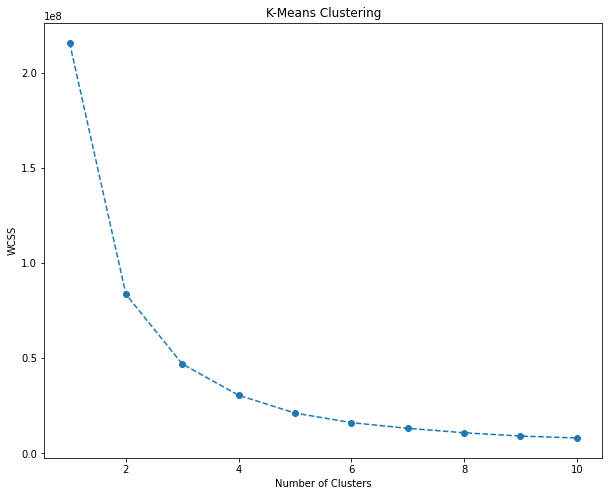

In [102]:
plt.figure(figsize=(10,8))
plt.plot(range(1,11),wcss, marker ='o', linestyle = '--')
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.title("K-Means Clustering")
plt.show()

In [103]:
std_final_user = sc.fit_transform(final_user)

In [104]:
std_final_user

array([[-0.32387299, -0.4226287 , -0.79786614, ...,  0.47254015,
        -0.62668769, -0.7017417 ],
       [-0.08246498,  0.31970512,  1.04098423, ...,  0.33192831,
         1.35819714,  1.07677068],
       [-0.20316898, -0.35742371, -0.5588156 , ..., -0.65235457,
        -0.62668769, -0.7017417 ],
       ...,
       [-0.504929  , -0.62827524, -1.01852819, ...,  1.45682302,
        -1.32139738, -1.29457917],
       [-0.44457699, -0.24206102, -0.15426851, ...,  0.89437566,
        -0.13046648,  0.18751449],
       [ 1.72809511,  0.09399551, -0.88980866, ..., -1.21480192,
        -1.12290889, -0.99816043]])

In [105]:
kmeans_user = KMeans(n_clusters = 4, init='k-means++', random_state = 40)

In [106]:
kmeans_user.fit(std_final_user)

KMeans(n_clusters=4, random_state=40)

In [107]:
df_segm_kmeans_user = final_user.copy()

In [108]:
df_segm_kmeans_user['Segment Kmeans'] = kmeans_user.labels_

In [109]:
df_segm_kmeans_analysis = df_segm_kmeans_user.groupby(['Segment Kmeans']).mean()

In [110]:
df_segm_kmeans_user

,Total_orders,Items_bought,Products,user_reorder,frequency,Max_cartsize,Avg_cartsize,Segment Kmeans
user_id,,,,,,,,
1,10,65,18,0.784615,19.0,11,4.0,2
2,14,213,118,0.492958,18.0,31,10.0,3
3,12,78,31,0.705128,11.0,11,4.0,2
4,5,14,14,0.071429,15.0,7,3.0,0
5,4,35,24,0.514286,12.0,12,5.0,2
...,...,...,...,...,...,...,...,...
4996,3,27,23,0.296296,30.0,18,7.0,0
4997,28,127,56,0.606299,6.0,8,3.0,2
4998,7,24,6,0.833333,26.0,4,2.0,2


In [111]:
df_segm_kmeans_analysis

,Total_orders,Items_bought,Products,user_reorder,frequency,Max_cartsize,Avg_cartsize
Segment Kmeans,,,,,,,
0,6.130011,43.068256,31.185807,0.325903,20.998375,12.313109,5.104550
1,52.742188,603.351562,166.402344,0.718658,7.216797,27.177734,8.056641
2,15.745443,96.100260,39.758464,0.618104,12.076172,11.694010,4.399089
3,12.953888,190.117541,93.228752,0.512828,15.542495,28.902351,10.426763


In [112]:
finaltest

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,988,45061,1,0,310,train,100,2,9,4.0
1,988,28464,2,0,310,train,100,2,9,4.0
2,988,12626,3,0,310,train,100,2,9,4.0
3,988,4818,4,1,310,train,100,2,9,4.0
4,1890,432,1,1,2454,train,4,5,6,30.0
...,...,...,...,...,...,...,...,...,...,...
746295,3420853,1919,3,1,3357,prior,5,5,11,13.0
746296,3420853,32020,4,0,3357,prior,5,5,11,13.0
746297,3420853,24943,5,0,3357,prior,5,5,11,13.0
746298,3420853,25197,6,1,3357,prior,5,5,11,13.0


In [113]:
departments

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


In [114]:
finaltest_dept = finaltest.merge(products[['product_id','department_id']],how='left',on='product_id')

In [115]:
user_dept = finaltest_dept.groupby(['user_id','department_id'])['product_id'].count().to_frame("Products").reset_index()

In [116]:
user_dept = pd.pivot_table(user_dept,values='Products',index='user_id',columns='department_id',fill_value=0)

In [117]:
nonveg = user_dept[user_dept[12]>=1]

In [118]:
nonveg_users = nonveg.index

In [119]:
veg = user_dept[user_dept[12]==0]

In [120]:
veg_users = veg.index

In [121]:
vegan = user_dept[(user_dept[12]==0) & (user_dept[16]==0)]

In [122]:
vegan_users = vegan.index

In [123]:
egg_users = list(set(veg_users)-set(vegan_users))

In [124]:
final_user = final_user.reset_index()

In [125]:
final_user

,user_id,Total_orders,Items_bought,Products,user_reorder,frequency,Max_cartsize,Avg_cartsize
0,1,10,65,18,0.784615,19.0,11,4.0
1,2,14,213,118,0.492958,18.0,31,10.0
2,3,12,78,31,0.705128,11.0,11,4.0
3,4,5,14,14,0.071429,15.0,7,3.0
4,5,4,35,24,0.514286,12.0,12,5.0
...,...,...,...,...,...,...,...,...
4995,4996,3,27,23,0.296296,30.0,18,7.0
4996,4997,28,127,56,0.606299,6.0,8,3.0
4997,4998,7,24,6,0.833333,26.0,4,2.0
4998,4999,8,101,53,0.574257,22.0,16,7.0


In [126]:
preference = []
for i in range(1,len(final_user)+1):
    if i in list(nonveg_users):
        preference.append("meat_eater")
        continue
    elif i in list(egg_users):
        preference.append("eggetarian")
        continue
    else:
        preference.append("vegan")
        continue

In [127]:
final_user = final_user.assign(food_choice = preference)

In [128]:
final_user

,user_id,Total_orders,Items_bought,Products,user_reorder,frequency,Max_cartsize,Avg_cartsize,food_choice
0,1,10,65,18,0.784615,19.0,11,4.0,eggetarian
1,2,14,213,118,0.492958,18.0,31,10.0,meat_eater
2,3,12,78,31,0.705128,11.0,11,4.0,eggetarian
3,4,5,14,14,0.071429,15.0,7,3.0,vegan
4,5,4,35,24,0.514286,12.0,12,5.0,eggetarian
...,...,...,...,...,...,...,...,...,...
4995,4996,3,27,23,0.296296,30.0,18,7.0,eggetarian
4996,4997,28,127,56,0.606299,6.0,8,3.0,eggetarian
4997,4998,7,24,6,0.833333,26.0,4,2.0,eggetarian
4998,4999,8,101,53,0.574257,22.0,16,7.0,eggetarian


In [130]:
data

,user_id,product_id,p_purchased,uxp_reorder_ratio,total_orders,user_reorder,(N)Product_purchased,product_reorder,add_to_cart
0,1,196,10,1.000000,65,0.784615,774,0.813953,4.0
1,1,10258,10,1.000000,65,0.784615,56,0.714286,4.0
2,1,10326,1,0.142857,65,0.784615,111,0.540541,4.0
3,1,12427,9,0.900000,65,0.784615,135,0.740741,5.0
4,1,13032,4,0.400000,65,0.784615,56,0.589286,5.0
...,...,...,...,...,...,...,...,...,...
306942,5000,21903,1,0.045455,168,0.946429,5433,0.816676,7.0
306943,5000,31805,2,0.062500,168,0.946429,159,0.647799,5.0
306944,5000,33395,2,0.047619,168,0.946429,10,0.600000,7.0
306945,5000,38768,42,0.976744,168,0.946429,334,0.811377,3.0


In [131]:
data_rec = data[['user_id','product_id','uxp_reorder_ratio','add_to_cart']]

In [132]:
data_rec

,user_id,product_id,uxp_reorder_ratio,add_to_cart
0,1,196,1.000000,4.0
1,1,10258,1.000000,4.0
2,1,10326,0.142857,4.0
3,1,12427,0.900000,5.0
4,1,13032,0.400000,5.0
...,...,...,...,...
306942,5000,21903,0.045455,7.0
306943,5000,31805,0.062500,5.0
306944,5000,33395,0.047619,7.0
306945,5000,38768,0.976744,3.0


In [154]:
ratingg = []
for i in range(0,len(data_rec)):
    if data_rec['add_to_cart'][i]==1:
        ratingg.append(data_rec['uxp_reorder_ratio'][i]*0.7+0.3)
    else:
        ratingg.append(data_rec['uxp_reorder_ratio'][i]*0.7+0.3*(1/np.log(data_rec['add_to_cart'][i])))
        

In [159]:
data_rec['rating'] = ratingg

In [164]:
data_rec['rating'] = data_rec['rating']*5/data_rec['rating'].max()

In [167]:
data_rec['rating'] = data_rec['rating'].apply(np.ceil)

In [168]:
data_rec['rating'].describe()

count    306947.000000
mean          2.054244
std           0.968399
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max           5.000000
Name: rating, dtype: float64

In [170]:
data_rec = data_rec.drop(['uxp_reorder_ratio','add_to_cart'],axis=1)

In [171]:
data_rec

,user_id,product_id,rating
0,1,196,5.0
1,1,10258,5.0
2,1,10326,2.0
3,1,12427,4.0
4,1,13032,3.0
...,...,...,...
306942,5000,21903,1.0
306943,5000,31805,2.0
306944,5000,33395,1.0
306945,5000,38768,5.0


In [172]:
data_rec_pivot = pd.pivot_table(data_rec,values='rating',index='user_id',columns='product_id')

In [173]:
#data_als['rating'] = data_als['rating'].apply(lambda x: ((x-data_als['rating'].min())/(data_als['rating'].max()-data_als['rating'].min()))*5)

In [174]:
data_rec['rating'].value_counts()

2.0    127742
1.0     99072
3.0     45936
4.0     32805
5.0      1392
Name: rating, dtype: int64

In [175]:
data_rec

,user_id,product_id,rating
0,1,196,5.0
1,1,10258,5.0
2,1,10326,2.0
3,1,12427,4.0
4,1,13032,3.0
...,...,...,...
306942,5000,21903,1.0
306943,5000,31805,2.0
306944,5000,33395,1.0
306945,5000,38768,5.0


In [192]:
data_rec[data_rec['product_id'] ==196]['rating'].mean()

2.9086021505376345

In [191]:
from surprise import KNNBasic
from surprise import Reader, Dataset

In [ ]:
from surprise import Reader, Dataset

In [193]:
data_rec

,user_id,product_id,rating
0,1,196,5.0
1,1,10258,5.0
2,1,10326,2.0
3,1,12427,4.0
4,1,13032,3.0
...,...,...,...
306942,5000,21903,1.0
306943,5000,31805,2.0
306944,5000,33395,1.0
306945,5000,38768,5.0


In [194]:
data_rec_pivot = data_rec_pivot.fillna(0)

In [195]:
from sklearn.metrics.pairwise import cosine_similarity
import operator

In [196]:
def similar_users(user_id, matrix, k=3):
    # create a df of just the current user
    user = matrix[matrix.index == user_id]
    
    # and a df of all other users
    other_users = matrix[matrix.index != user_id]
    
    # calc cosine similarity between user and each other user
    similarities = cosine_similarity(user,other_users)[0].tolist()
    
    # create list of indices of these users
    indices = other_users.index.tolist()
    
    # create key/values pairs of user index and their similarity
    index_similarity = dict(zip(indices, similarities))
    
    # sort by similarity
    index_similarity_sorted = sorted(index_similarity.items(), key=operator.itemgetter(1))
    index_similarity_sorted.reverse()
    
    # grab k users off the top
    top_users_similarities = index_similarity_sorted[:k]
    users = [u[0] for u in top_users_similarities]
    
    return users

In [253]:
current_user = 3

In [254]:
similar_user_indices = similar_users(current_user, data_rec_pivot)

In [228]:
print(similar_user_indices)

[4126, 3951, 3006]


In [255]:
def recommend_item(user_index, similar_user_indices, matrix, items=5):
    user_preference = {"user_id":[],"product_id":[]}
    # load vectors for similar users
    similar_users = matrix[matrix.index.isin(similar_user_indices)]
    # calc avg ratings across the 3 similar users
    similar_users = similar_users.mean(axis=0)
    # convert to dataframe so its easy to sort and filter
    similar_users_df = pd.DataFrame(similar_users, columns=['mean'])
    
    
    # load vector for the current user
    user_df = matrix[matrix.index == user_index]
    # transpose it so its easier to filter
    user_df_transposed = user_df.transpose()
    # rename the column as 'rating'
    user_df_transposed.columns = ['rating']
    # remove any rows without a 0 value. Products not bought
    user_df_transposed = user_df_transposed[user_df_transposed['rating']==0]
    # generate a list of products the user has not bought
    products_unseen = user_df_transposed.index.tolist()
    
    # filter avg ratings of similar users for only product the current user has not bought
    similar_users_df_filtered = similar_users_df[similar_users_df.index.isin(products_unseen)]
    # order the dataframe
    similar_users_df_ordered = similar_users_df.sort_values(by=['mean'], ascending=False)
    # grab the top n products   
    top_n_products = similar_users_df_ordered.head(items)
    top_n_products_indices = top_n_products.index.tolist()
    # lookup these products in the other dataframe to find names
    product_information = products[products['product_id'].isin(top_n_products_indices)]
    user_preference['user_id'].append(user_index)
    user_preference['product_id'].append(top_n_products_indices)
    user_preference
    return user_preference #items
# try it out


In [ ]:
recommend_item(226, similar_user_indices, rating_matrix)

In [258]:
recommendation_list = []
for i in range(1,len(data_rec_pivot)+1):
    current_user = i
    similar_user_indices = similar_users(current_user, data_rec_pivot)
    recommendation_list.append(recommend_item(i, similar_user_indices, data_rec_pivot))
    
    

ValueError: Found array with 0 sample(s) (shape=(0, 28667)) while a minimum of 1 is required by check_pairwise_arrays.

In [271]:
userindex = []
productindex = []
for i in range(0,len(recommendation_list)):
    pd.DataFrame.from_dict(data)
    

list

In [278]:
userdf = pd.DataFrame(recommendation_list)

In [300]:
userdf.to_csv("recommendation_final.csv")

In [304]:
df_segm_kmeans.to_csv("kmeans_product.csv")

In [305]:
final_user.to_csv("final_user.csv")

In [308]:
df_segm_kmeans_user['preference'] = preference

In [309]:
df_segm_kmeans_user.to_csv("kmeans_user.csv")

In [310]:
data

,user_id,product_id,p_purchased,uxp_reorder_ratio,total_orders,user_reorder,(N)Product_purchased,product_reorder,add_to_cart
0,1,196,10,1.000000,65,0.784615,774,0.813953,4.0
1,1,10258,10,1.000000,65,0.784615,56,0.714286,4.0
2,1,10326,1,0.142857,65,0.784615,111,0.540541,4.0
3,1,12427,9,0.900000,65,0.784615,135,0.740741,5.0
4,1,13032,4,0.400000,65,0.784615,56,0.589286,5.0
...,...,...,...,...,...,...,...,...,...
306942,5000,21903,1,0.045455,168,0.946429,5433,0.816676,7.0
306943,5000,31805,2,0.062500,168,0.946429,159,0.647799,5.0
306944,5000,33395,2,0.047619,168,0.946429,10,0.600000,7.0
306945,5000,38768,42,0.976744,168,0.946429,334,0.811377,3.0


In [312]:
finaltest.to_csv("orders_sprint5.csv")

In [313]:
data.to_csv("user_data.csv")

In [331]:
df_segm_kmeans_user.groupby('Segment Kmeans').mean().reset_index()

,Segment Kmeans,Total_orders,Items_bought,Products,user_reorder,frequency,Max_cartsize,Avg_cartsize
0,0,6.130011,43.068256,31.185807,0.325903,20.998375,12.313109,5.104550
1,1,52.742188,603.351562,166.402344,0.718658,7.216797,27.177734,8.056641
2,2,15.745443,96.100260,39.758464,0.618104,12.076172,11.694010,4.399089
3,3,12.953888,190.117541,93.228752,0.512828,15.542495,28.902351,10.426763


In [324]:
label3 = []
for i in df_segm_kmeans_user['Segment Kmeans']:
    if i==0:
        label3.append("Low-Value")
    elif i==1:
        label3.append("Loyal")
    elif i==2:
        label3.append("Insistent")
    else:
        label3.append("Occasional")
   

In [325]:
label3

['Insistent',
 'Occasional',
 'Insistent',
 'Low-Value',
 'Insistent',
 'Low-Value',
 'Occasional',
 'Low-Value',
 'Occasional',
 'Occasional',
 'Low-Value',
 'Low-Value',
 'Insistent',
 'Occasional',
 'Insistent',
 'Low-Value',
 'Insistent',
 'Insistent',
 'Occasional',
 'Insistent',
 'Insistent',
 'Insistent',
 'Low-Value',
 'Insistent',
 'Low-Value',
 'Insistent',
 'Loyal',
 'Occasional',
 'Insistent',
 'Insistent',
 'Occasional',
 'Occasional',
 'Low-Value',
 'Low-Value',
 'Occasional',
 'Insistent',
 'Insistent',
 'Occasional',
 'Occasional',
 'Insistent',
 'Low-Value',
 'Occasional',
 'Occasional',
 'Low-Value',
 'Low-Value',
 'Insistent',
 'Low-Value',
 'Low-Value',
 'Low-Value',
 'Loyal',
 'Low-Value',
 'Insistent',
 'Low-Value',
 'Loyal',
 'Occasional',
 'Insistent',
 'Insistent',
 'Insistent',
 'Occasional',
 'Low-Value',
 'Low-Value',
 'Low-Value',
 'Loyal',
 'Insistent',
 'Insistent',
 'Low-Value',
 'Insistent',
 'Low-Value',
 'Insistent',
 'Low-Value',
 'Occasional',
 'Ins

In [326]:
df_segm_kmeans_user['Type of User'] = label3

In [328]:
df_segm_kmeans_user.to_csv("kmeans_user2.csv")

In [335]:
df_segm_kmeans_user.groupby('Type of User').mean().reset_index().to_csv("segm_means_final.csv")

In [336]:
finaltest

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,988,45061,1,0,310,train,100,2,9,4.0
1,988,28464,2,0,310,train,100,2,9,4.0
2,988,12626,3,0,310,train,100,2,9,4.0
3,988,4818,4,1,310,train,100,2,9,4.0
4,1890,432,1,1,2454,train,4,5,6,30.0
...,...,...,...,...,...,...,...,...,...,...
746295,3420853,1919,3,1,3357,prior,5,5,11,13.0
746296,3420853,32020,4,0,3357,prior,5,5,11,13.0
746297,3420853,24943,5,0,3357,prior,5,5,11,13.0
746298,3420853,25197,6,1,3357,prior,5,5,11,13.0


In [338]:
weekday = []
for i in range(0,len(finaltest)):
    if finaltest['order_dow'][i]== 0:
        weekday.append("Sunday")
        continue
    elif finaltest['order_dow'][i] == 1:
        weekday.append("Monday")
        continue
    elif finaltest['order_dow'][i] == 2:
        weekday.append("Tuesday")
        continue
    elif finaltest['order_dow'][i] ==3:
        weekday.append("Wednesday")
        continue
    elif finaltest['order_dow'][i] == 4:
        weekday.append("Thursday")
        continue
    elif finaltest['order_dow'][i] == 5:
        weekday.append("Friday")
        continue
    else:
        weekday.append("Saturday")
        continue
        
    

In [341]:
finaltest['Weekday'] = weekday

In [342]:
finaltest.to_csv("anything.csv")

In [343]:
final_user

,user_id,Total_orders,Items_bought,Products,user_reorder,frequency,Max_cartsize,Avg_cartsize,food_choice
0,1,10,65,18,0.784615,19.0,11,4.0,eggetarian
1,2,14,213,118,0.492958,18.0,31,10.0,meat_eater
2,3,12,78,31,0.705128,11.0,11,4.0,eggetarian
3,4,5,14,14,0.071429,15.0,7,3.0,vegan
4,5,4,35,24,0.514286,12.0,12,5.0,eggetarian
...,...,...,...,...,...,...,...,...,...
4995,4996,3,27,23,0.296296,30.0,18,7.0,eggetarian
4996,4997,28,127,56,0.606299,6.0,8,3.0,eggetarian
4997,4998,7,24,6,0.833333,26.0,4,2.0,eggetarian
4998,4999,8,101,53,0.574257,22.0,16,7.0,eggetarian


In [345]:
finaltest[finaltest['user_id']==2]

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,Weekday
14966,1492625,22963,1,1,2,train,15,1,11,30.0,Monday
14967,1492625,7963,2,1,2,train,15,1,11,30.0,Monday
14968,1492625,16589,3,1,2,train,15,1,11,30.0,Monday
14969,1492625,32792,4,1,2,train,15,1,11,30.0,Monday
14970,1492625,41787,5,1,2,train,15,1,11,30.0,Monday
...,...,...,...,...,...,...,...,...,...,...,...
714675,3268552,44303,5,0,2,prior,13,4,11,30.0,Thursday
714676,3268552,16521,6,0,2,prior,13,4,11,30.0,Thursday
714677,3268552,39877,7,0,2,prior,13,4,11,30.0,Thursday
714678,3268552,19057,8,0,2,prior,13,4,11,30.0,Thursday


In [348]:
data_rec

,user_id,product_id,rating
0,1,196,5.0
1,1,10258,5.0
2,1,10326,2.0
3,1,12427,4.0
4,1,13032,3.0
...,...,...,...
306942,5000,21903,1.0
306943,5000,31805,2.0
306944,5000,33395,1.0
306945,5000,38768,5.0
